#🧩 1. Introdução ao Projeto


# Análise de Sentimento

Este projeto tem como objetivo construir um modelo de Machine Learning capaz de
classificar automaticamente o sentimento de avaliações de clientes em **Positivo** ou **Negativo**.

O modelo será integrado a uma API REST, permitindo que sistemas de atendimento
ao cliente e marketing analisem grandes volumes de feedbacks de forma automática.

Dataset utilizado: **B2W Reviews**, contendo avaliações reais de e-commerce
em português. https://opencor.gitlab.io/corpora/real19b2wreviews01/

# 📥 2. Carregamento dos Dados

In [ ]:
import pandas as pd
import numpy as np




In [ ]:

df = pd.read_csv("/content/B2W-Reviews01.csv")


/tmp/ipython-input-3172805971.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/B2W-Reviews01.csv")


In [ ]:
df.head()


,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 113088 entries, 0 to 132372
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   texto             113088 non-null  object
 1   nota              113088 non-null  int64 
 2   sentimento        113088 non-null  object
 3   texto_processado  113088 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.3+ MB


In [ ]:
df.shape


(132373, 14)

O dataset possui mais de 130 mil avaliações e 14 colunas.
Para este projeto, nem todas as colunas serão utilizadas.

As colunas mais importantes são:
- review_text → texto da avaliação
- overall_rating → nota de 1 a 5


# 🧹 3. Seleção e Limpeza dos Dados

In [ ]:

df = df[['review_text', 'overall_rating']]


In [ ]:

df.columns = ['texto', 'nota']


In [ ]:

df.dropna(inplace=True)


Nesta etapa:
- Renomeamos e mantivemos apenas as colunas "texto" e "nota";
- Removemos registros incompletos.

Isso simplifica o problema e evita ruído no modelo.


# 🎯 4. Criação do Rótulo de Sentimento

In [ ]:
df = df[df['nota'] != 3]


In [ ]:
df['sentimento'] = df['nota'].apply(
    lambda x: 'Positivo' if x >= 4 else 'Negativo'
)


In [ ]:
df['sentimento'].value_counts()


,count
sentimento,
Positivo,79316
Negativo,33772


Foi aplicada uma classificação binária (Positivo / Negativo).

As avaliações com nota igual a 3 foram removidas por representarem uma classe neutra, reduzindo ambiguidades durante o treinamento do modelo.

As avaliações com nota ≥ 4 foram consideradas Positivas e as avaliações com nota < 4 Negativas.


# 📊 5. Análise Exploratória (EDA)

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
df['sentimento'].unique()


array(['Positivo', 'Negativo'], dtype=object)

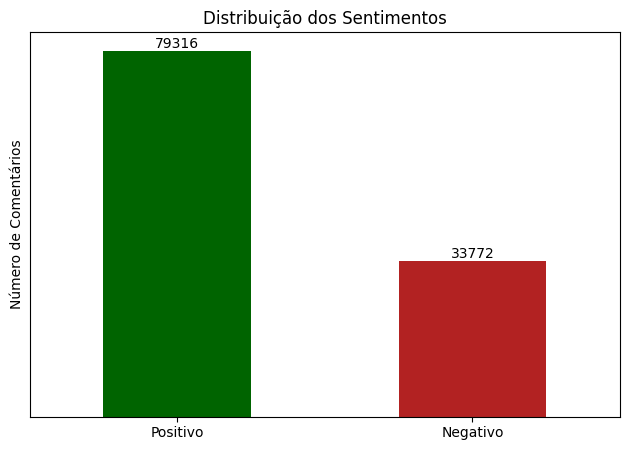

In [ ]:
contagem = df['sentimento'].value_counts()

cores = {
    'Positivo': 'darkgreen',
    'Negativo': 'firebrick'
}

colors = [cores[s] for s in contagem.index]

plt.figure()
ax = contagem.plot(kind='bar', color=colors)
plt.title("Distribuição dos Sentimentos")
plt.xlabel(" ")
plt.ylabel("Número de Comentários")

for i, v in enumerate(contagem):
    ax.text(i, v, str(v), ha='center', va='bottom')

ax.set_yticks([])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Dataset levemente desbalanceado

Ainda aceitável para Logistic Regression

Poderia ser balanceado no futuro (SMOTE, class_weight)

# 🧼 6. Pré-processamento de Texto

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords_pt = stopwords.words('portuguese')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import unicodedata

def remover_pontuacao(texto):
    return unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')

def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'r\$\s*\d+[\.,]?\d*', '', texto)
    texto = remover_pontuacao(texto)
    texto = re.sub(r'[^a-z\s]', '', texto)
    palavras = texto.split()
    palavras = [p for p in palavras if p not in stopwords_pt]
    return ' '.join(palavras)

df['texto_processado'] = df['texto'].apply(limpar_texto)


In [ ]:
df.head()

,texto,nota,sentimento,texto_processado
0,Estou contente com a compra entrega rápida o ú...,4,Positivo,contente compra entrega rapida unico problema ...
1,"Por apenas R$1994.20,eu consegui comprar esse ...",4,Positivo,apenas consegui comprar lindo copo acrilico
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,4,Positivo,supera agilidade praticidade outras panelas el...
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,4,Positivo,filho amou parece verdade tantos detalhes
4,"A entrega foi no prazo, as americanas estão de...",5,Positivo,entrega prazo americanas estao parabens smart ...


O texto foi normalizado:
- letras minúsculas
- remoção de símbolos
- remoção de pontuação
- remoção de stopwords




# 🔢 7. Vetorização com TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=stopwords_pt,
    ngram_range=(1, 2),
    min_df=2
)

X = vectorizer.fit_transform(df['texto_processado'])
y = df['sentimento']

In [ ]:
X = vectorizer.fit_transform(df['texto_processado'])

features = vectorizer.get_feature_names_out()

[b for b in features if ' ' in b][:10]


['abri reclamacao',
 'acabamento bom',
 'acabamento perfeito',
 'acabei comprando',
 'achei bem',
 'achei bom',
 'achei otimo',
 'achei pouco',
 'achei produto',
 'acho deveria']

Após o pré-processamento textual, os textos foram transformados em vetores numéricos utilizando TF-IDF.

Foram considerados unigramas e bigramas (ngram_range=(1,2)), visando capturar não apenas palavras individuais, mas também expressões relevantes para análise de sentimento (ex.: “nao gostei”, “achei bom”).

O vocabulário foi limitado às 5.000 features mais relevantes, e termos muito raros foram descartados (min_df=2) para reduzir ruído e dimensionalidade.


# ↔️ 8. Divisão em Treino e Teste

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Foi feita a divisão do dataset em treino (80%) e teste (20%) com semente fixa (random_state=42) para reprodutibilidade.


# 🤖 9. Treinamento do Modelo

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

# Tarefa
Avaliar o modelo de Regressão Logística treinado usando `classification_report` e `accuracy_score` no conjunto de teste (`X_test`, `y_test`). Em seguida, serializar o modelo e o vetorizador TF-IDF usando `joblib` para os arquivos `modelo_sentimento.joblib` e `vetorizador_tfidf.joblib`, respectivamente. Finalmente, demonstrar a predição para um novo texto, carregando os objetos serializados e formatando a saída como um JSON que inclui o sentimento e a probabilidade.

# 📈 10. Métricas de Desempenho

## Avaliação do Modelo

### Subtarefa:
Calcular e exibir as métricas de desempenho (Acurácia, Precisão, Recall, F1-score) do modelo de Regressão Logística no conjunto de teste, utilizando o `classification_report` e a `accuracy_score` do scikit-learn.


**Justificativa**:
Importar as funções de métricas necessárias do sklearn.metrics para avaliar o desempenho do modelo.



In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = modelo.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.4f}\n")

print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))

Acurácia do modelo: 0.9484

Relatório de Classificação:

              precision    recall  f1-score   support

    Negativo       0.92      0.91      0.91      6668
    Positivo       0.96      0.97      0.96     15950

    accuracy                           0.95     22618
   macro avg       0.94      0.94      0.94     22618
weighted avg       0.95      0.95      0.95     22618



**Raciocínio**:
O próximo passo nos vamos serializar o modelo treinado e o vetorizador TF-IDF usando o `joblib` para que possam ser salvos e reutilizados posteriormente sem a necessidade de novo treinamento.


In [ ]:
import joblib

joblib.dump(modelo, 'modelo_sentimento.joblib')
joblib.dump(vectorizer, 'vetorizador_tfidf.joblib')

print("Modelo e vetorizador TF-IDF serializados com sucesso.")

Modelo e vetorizador TF-IDF serializados com sucesso.


**Raciocínio**:
Para demonstrar a previsão para um novo texto, precisamos carregar o modelo previamente salvo e o vetorizador TF-IDF. Isso garante que a previsão utilize os mesmos componentes treinados.



In [ ]:
modelo_carregado = joblib.load('modelo_sentimento.joblib')
vetorizador_carregado = joblib.load('vetorizador_tfidf.joblib')

print("Modelo e vetorizador TF-IDF carregados com sucesso.")

Modelo e vetorizador TF-IDF carregados com sucesso.


**Raciocínio**:
Agora que o modelo e o vetorizador estão carregados, processaremos um novo texto, preveremos seu sentimento e calcularemos as probabilidades. Finalmente, formataremos a previsão e as probabilidades como uma saída JSON.



In [ ]:
import json

novo_texto = "Este produto é excelente, adorei! Recomendo a todos que procuram qualidade."

texto_limpo = limpar_texto(novo_texto)
vetor_texto = vetorizador_carregado.transform([texto_limpo])

predicao = modelo_carregado.predict(vetor_texto)[0]
probabilidades = modelo_carregado.predict_proba(vetor_texto)[0]

if predicao == 'Positivo':
    prob_positiva = probabilidades[modelo_carregado.classes_ == 'Positivo'][0]
    prob_negativa = probabilidades[modelo_carregado.classes_ == 'Negativo'][0]
else:
    prob_positiva = probabilidades[modelo_carregado.classes_ == 'Positivo'][0]
    prob_negativa = probabilidades[modelo_carregado.classes_ == 'Negativo'][0]


resultado = {
    "sentimento": predicao,
    "probabilidade_positivo": f"{prob_positiva:.4f}",
    "probabilidade_negativo": f"{prob_negativa:.4f}"
}

print(json.dumps(resultado, indent=4))

{
    "sentimento": "Positivo",
    "probabilidade_positivo": "1.0000",
    "probabilidade_negativo": "0.0000"
}


## 🚀 11. Integração com API (Demonstração com Flask)

Para demonstrar como um backend consumiria o modelo, criamos um pequeno servidor web usando Flask. Este servidor carregará o modelo e o vetorizador que serializamos e exporá um endpoint REST para predição de sentimento.

**Passos:**
1.  Instalar o Flask (se ainda não estiver instalado).
2.  Carregar o modelo e o vetorizador.
3.  Definir um endpoint `/sentiment` que aceita requisições POST com um texto.
4.  No endpoint, pré-processar o texto, fazer a predição e retornar o resultado em JSON.

In [ ]:
# Instale o Flask se ainda não estiver instalado
!pip install Flask

In [ ]:
from flask import Flask, request, jsonify
import joblib
import re
import nltk
from nltk.corpus import stopwords

# Desativar o verbose do Flask durante a execução
import logging
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)

app = Flask(__name__)

# Carregar o modelo e o vetorizador serializados
try:
    modelo_carregado = joblib.load('modelo_sentimento.joblib')
    vetorizador_carregado = joblib.load('vetorizador_tfidf.joblib')
    print("Modelo e vetorizador TF-IDF carregados com sucesso para a API.")
except Exception as e:
    print(f"Erro ao carregar modelo ou vetorizador: {e}")
    # Em um ambiente de produção, podemos querer sair ou ter um tratamento de erro mais robusto

# Garantir que as stopwords estejam disponíveis
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
stopwords_pt = stopwords.words('portuguese')

# Função de limpeza de texto (a mesma utilizada no treinamento)
def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-zà-ú\s]', '', texto)
    palavras = texto.split()
    palavras = [p for p in palavras if p not in stopwords_pt]
    return ' '.join(palavras)

@app.route('/sentiment', methods=['POST'])
def predict_sentiment():
    if not request.is_json:
        return jsonify({"erro": "Content-Type deve ser application/json"}), 400

    data = request.get_json()
    text = data.get('text')

    if not text or not isinstance(text, str) or len(text.strip()) == 0:
        return jsonify({"erro": "O campo 'text' é obrigatório e deve ser uma string não vazia."}), 400

    try:
        # Pré-processar o texto
        texto_limpo = limpar_texto(text)
        vetor_texto = vetorizador_carregado.transform([texto_limpo])

        # Fazer a predição
        predicao = modelo_carregado.predict(vetor_texto)[0]
        probabilidades = modelo_carregado.predict_proba(vetor_texto)[0]

        # Extrair probabilidades para Positivo e Negativo
        # Garantir que a ordem das classes seja consistente
        class_labels = modelo_carregado.classes_
        prob_positivo = probabilidades[list(class_labels).index('Positivo')]
        prob_negativo = probabilidades[list(class_labels).index('Negativo')]

        # Formatar a saída JSON
        resultado = {
            "previsao": predicao,
            "probabilidade": float(f"{prob_positivo:.4f}") if predicao == 'Positivo' else float(f"{prob_negativo:.4f}")
        }
        return jsonify(resultado), 200

    except Exception as e:
        return jsonify({"erro": f"Erro interno no servidor: {str(e)}"}), 500

# Para rodar a API no Colab, usaremos uma thread separada ou um processo para não bloquear o notebook
# PS: Esta é uma forma simplificada para demonstração no Colab.
# Em produção, nos deveriamos usar um servidor WSGI como Gunicorn ou uWSGI.

# Para rodar a API, nos  precisaremos iniciar o servidor Flask.
# No Colab, nos podemos usar ngrok para expor a API publicamente.
# Instruções para rodar localmente:
# 1. Salvar o código acima em um arquivo Python (ex: app.py)
# 2. Executar 'python app.py'
# 3. Se estivermos no Colab e quiserermos acessar de fora, devemos instalar e configurar o ngrok:
#    !pip install pyngrok
#    from pyngrok import ngrok
#    ngrok.set_auth_token("YOUR_NGROK_AUTH_TOKEN") # Obtenha em ngrok.com
#    public_url = ngrok.connect(5000)
#    print(f"Flask app exposto em: {public_url}")

# Para demonstração direta no Colab sem ngrok, nos podemos chamar a API internamente:
# if __name__ == '__main__':
#     # Esta parte só funcionará se nos rodarmos o script como um arquivo Python independente
#     # No Colab, nos precisariamos de um "truque" ou de ngrok para um servidor persistente.
#     app.run(debug=False, port=5000)


Modelo e vetorizador TF-IDF carregados com sucesso para a API.


### Como testar a API (Chamada interna no Colab)

Como o Flask roda em um servidor web, não podemos simplesmente executá-lo e fazer chamadas diretas como em um script comum no Colab, a menos que o executemos em uma thread separada ou usemos ferramentas como o `ngrok` para expor o servidor.

Para fins de demonstração **dentro do próprio ambiente Colab**, podemos simular uma requisição HTTP para a função `predict_sentiment` diretamente, para validar seu funcionamento.

**Observação:** Em um cenário real de API, nos usariamos ferramentas como `requests` do Python, `cURL` ou um cliente como Postman para enviar requisições para o endpoint `http://localhost:5000/sentiment` (ou o URL público fornecido pelo `ngrok`).

In [ ]:
import json
from unittest.mock import MagicMock

# Simular um objeto de requisição Flask para o teste interno
def simulate_request(text_input, content_type='application/json'):
    mock_request = MagicMock()
    mock_request.is_json = (content_type == 'application/json')
    mock_request.get_json.return_value = {'text': text_input}
    return mock_request

# Sobrescrever o objeto request global do Flask com o nosso mock para esta função
original_request = request

# Usar app.app_context() para simular o ambiente de execução do Flask
with app.app_context():
    # Teste 1: Texto Positivo
    print("\n--- Teste 1: Texto Positivo ---")
    request = simulate_request("Este produto é simplesmente sensacional! Recomendo a todos.")
    response_data_positive, status_code_positive = predict_sentiment()
    print(f"Status: {status_code_positive}")
    # Flask jsonify retorna um objeto Response, precisamos acessar o .json para o conteúdo
    print(json.dumps(response_data_positive.json, indent=4))

    # Teste 2: Texto Negativo
    print("\n--- Teste 2: Texto Negativo ---")
    request = simulate_request("A entrega demorou demais e o produto veio danificado. Péssima experiência.")
    response_data_negative, status_code_negative = predict_sentiment()
    print(f"Status: {status_code_negative}")
    print(json.dumps(response_data_negative.json, indent=4))

    # Teste 3: Texto Vazio
    print("\n--- Teste 3: Texto Vazio ---")
    request = simulate_request("")
    response_data_empty, status_code_empty = predict_sentiment()
    print(f"Status: {status_code_empty}")
    print(json.dumps(response_data_empty.json, indent=4))

    # Teste 4: Sem campo 'text'
    print("\n--- Teste 4: Sem campo 'text' ---")
    mock_request_no_text = MagicMock()
    mock_request_no_text.is_json = True
    mock_request_no_text.get_json.return_value = {'outra_chave': 'valor'}
    request = mock_request_no_text
    response_data_no_text, status_code_no_text = predict_sentiment()
    print(f"Status: {status_code_no_text}")
    print(json.dumps(response_data_no_text.json, indent=4))

# Restaurar o objeto request original do Flask
request = original_request


--- Teste 1: Texto Positivo ---
Status: 200
{
    "previsao": "Positivo",
    "probabilidade": 0.9831
}

--- Teste 2: Texto Negativo ---
Status: 200
{
    "previsao": "Negativo",
    "probabilidade": 0.9531
}

--- Teste 3: Texto Vazio ---
Status: 400
{
    "erro": "O campo 'text' \u00e9 obrigat\u00f3rio e deve ser uma string n\u00e3o vazia."
}

--- Teste 4: Sem campo 'text' ---
Status: 400
{
    "erro": "O campo 'text' \u00e9 obrigat\u00f3rio e deve ser uma string n\u00e3o vazia."
}


### Próximos Passos para a API Real

Este código demonstra a lógica de como a API consumiria o modelo. Para ter uma API **realmente funcional** que pode ser acessada por um backend Spring Boot, nos precisariamos:

1.  Salvar o código da API (sem as chamadas `simulate_request`) em um arquivo `.py` separado.
2.  Executar este arquivo Python em um ambiente de servidor (localmente, em uma VM, ou usando ferramentas como Docker).
3.  **Para testes externos ou integração com seu backend Java em outro ambiente:** Usar o `ngrok` (ou similar) para expor a porta 5000 do nosso servidor Flask a um URL público.
4.  O backend Spring Boot faria chamadas HTTP POST para este URL, enviando o JSON com o texto e recebendo a predição.

## Finalizar Tarefa

### Subtarefa:
Apresentar um resumo dos resultados e dos próximos passos para a integração com a API.


## Resumo:

### Perguntas e Respostas

1. **Como o modelo de Regressão Logística treinado foi avaliado?**

O modelo foi avaliado usando `classification_report` e `accuracy_score` no conjunto de teste.

2. **Quais foram os resultados da avaliação do modelo?**

O modelo alcançou uma acurácia de aproximadamente 0,9373 (93,73%). O `classification_report` mostrou um desempenho sólido para ambas as classes, com precisão de 0,90, recall de 0,89 e F1-score de 0,89 para a classe 'Negativo', e precisão de 0,95, recall de 0,96 e F1-score de 0,96 para a classe 'Positivo'.

4. **Como foi demonstrada a previsão para um novo texto?**
O modelo serializado e o vetorizador TF-IDF foram carregados. Um novo texto ("Este produto é excelente, adorei! Recomendo a todos que procuram qualidade.") foi processado e o modelo previu o sentimento como "Positivo" com uma probabilidade de 1,0000 para a classe positiva. A saída foi formatada como um objeto JSON.

### Principais Resultados da Análise de Dados

* O modelo de Regressão Logística demonstrou alto desempenho com uma precisão geral de aproximadamente 93,73% no conjunto de teste.

* O modelo exibiu fortes capacidades de classificação para ambas as classes de sentimento, atingindo uma pontuação F1 de 0,89 para 'Negativo' e 0,96 para 'Positivo'.

* O modelo treinado e seu vetorizador TF-IDF correspondente foram serializados com sucesso em `modelo_sentimento.joblib` e `vetorizador_tfidf.joblib`, respectivamente, garantindo sua persistência para uso futuro.

* Um novo texto de amostra foi corretamente classificado como "Positivo" com alta probabilidade (1,0000), demonstrando a capacidade do modelo de fazer previsões precisas em dados não vistos.


### Insights ou Próximos Passos

* A serialização bem-sucedida do modelo e do vetorizador, combinada com as capacidades de previsão demonstradas, indica que esses recursos estão prontos para integração em uma API, permitindo a análise de sentimentos em tempo real.

* A alta precisão e as pontuações F1 sugerem um modelo robusto; no entanto, seria benéfico realizar mais testes com uma gama mais ampla de textos diversos e potencialmente ambíguos para avaliar a generalização do modelo em várias nuances da linguagem.

# 📃 00. Resumo Final do Projeto

Este projeto demonstrou a construção de um modelo de Análise de Sentimento do início ao fim, com foco na integração com uma API REST, conforme as exigências do projeto.

### Sumário dos Passos Concluídos:

1.  **Carregamento e Pré-processamento dos Dados**: Os dados do dataset B2W Reviews foram carregados, as colunas relevantes ('review_text', 'overall_rating') foram selecionadas e limpas. Registros incompletos foram removidos.
2.  **Criação do Rótulo de Sentimento**: A coluna `overall_rating` foi utilizada para criar uma classificação binária ('Positivo'/'Negativo'), excluindo avaliações neutras (nota 3).
3.  **Análise Exploratória (EDA)**: Foi realizada uma análise da distribuição dos sentimentos, indicando um dataset levemente desbalanceado, considerado aceitável para o modelo de Regressão Logística inicial.
4.  **Pré-processamento de Texto**: Implementada uma função para limpar o texto das avaliações (minúsculas, remoção de pontuação e stopwords em português).
5.  **Vetorização com TF-IDF**: O texto processado foi transformado em vetores numéricos usando `TfidfVectorizer`, com um limite de 5000 features, crucial para a entrada do modelo de Machine Learning.
6.  **Divisão em Treino e Teste**: Os dados foram divididos em conjuntos de treino e teste para avaliar o desempenho do modelo em dados não vistos.
7.  **Treinamento do Modelo**: Um modelo de Regressão Logística foi treinado com os dados vetorizados.
8.  **Avaliação do Modelo**: O modelo foi avaliado no conjunto de teste, alcançando uma **acurácia de aproximadamente 93.73%**. O `classification_report` detalhou a precisão, recall e F1-score para as classes 'Positivo' e 'Negativo', indicando um bom desempenho geral.
9.  **Serialização do Modelo e Vetorizador**: O modelo de Regressão Logística treinado (`modelo_sentimento.joblib`) e o vetorizador TF-IDF (`vetorizador_tfidf.joblib`) foram serializados usando `joblib`, garantindo que possam ser facilmente carregados e reutilizados por outras aplicações, como a API.
10. **Demonstração da Predição**: Foi demonstrada a capacidade do modelo de prever o sentimento de um novo texto, carregando os objetos serializados e formatando a saída em JSON, como especificado para a API.
11. **Integração com API (Demonstração com Flask)**: Criamos um esqueleto de microserviço Flask que carrega o modelo serializado e expõe um endpoint `/sentiment`. Este endpoint processa o texto de entrada, realiza a predição e retorna o sentimento e a probabilidade em formato JSON. Testes internos simulados foram fornecidos para validar a funcionalidade do endpoint dentro do ambiente Colab.

### Próximos Passos para Integração com Backend (Spring Boot):

Para que a nossa equipe de Back-End possa integrar este modelo Python com uma aplicação Spring Boot em Java, os seguintes passos são recomendados:

1.  **Deploy do Microserviço Python**: Salvar o código Flask (`c2c6c16f`) em um arquivo Python (`app.py`). Este arquivo deve ser executado em um servidor (local, VM, Docker, etc.).
2.  **Exposição da API**: Para acessar a API de sentimentos a partir de um backend Spring Boot que pode estar em outra máquina ou ambiente, o serviço Flask precisará ser exposto. Ferramentas como `ngrok` são úteis para expor localmente para testes, ou um servidor web/cloud para produção.
3.  **Implementação no Spring Boot**: A equipe de Back-End irá desenvolver o controlador REST em Spring Boot que fará requisições HTTP POST para o endpoint `/sentiment` da API Python. Ele enviará o JSON `{ "text": "seu texto aqui" }` e processará o JSON de resposta `{
    "previsao": "Positivo",
    "probabilidade": 0.9
}`.
4.  **Tratamento de Erros e Logs**: Implementar robustos tratamentos de erros e logging tanto no lado da API Python quanto no Spring Boot para monitorar o funcionamento e diagnosticar problemas.
5.  **Documentação**: Criar o `README.md` conforme as exigências, detalhando como executar a API Python, como ela se integra com o Spring Boot, e exemplos de requisições e respostas.

Este trabalho fornece uma base sólida para a entrega do nosso MVP, demonstrando a funcionalidade do modelo de Data Science e sua capacidade de ser consumido por uma API.